## Initial Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataloader import read_activity
import pandas as pd
import numpy as np

## Load a workout

In [60]:
# https://www.strava.com/activities/5094620458/overview 
points, laps, events = read_activity("data/activities/5431221291.fit")

In [4]:
points#[100:110]

,Timestamp,speed,cadence,x,y,time_after_start,track_x,track_y,dist_to_track
0,2021-04-05 23:18:05+00:00,2.118,171.0,-320.043324,-208.706162,239.0,-32.379742,-59.041433,324.268203
1,2021-04-05 23:18:13+00:00,3.256,172.0,-302.545618,-187.851379,247.0,-32.887144,-58.028058,299.282119
2,2021-04-05 23:18:19+00:00,3.312,174.0,-288.685740,-172.953639,253.0,-33.248398,-57.254682,280.418409
3,2021-04-05 23:18:21+00:00,3.303,174.0,-283.659600,-171.146846,255.0,-33.227685,-57.300328,275.094845
4,2021-04-05 23:18:27+00:00,3.406,174.0,-262.909578,-172.385380,261.0,-32.709273,-58.392328,256.878563
...,...,...,...,...,...,...,...,...,...
222,2021-04-05 23:48:13+00:00,3.331,170.0,-604.335148,-63.228218,2047.0,-36.477914,-43.464574,568.201056
223,2021-04-05 23:48:19+00:00,3.359,170.0,-625.745111,-60.002158,2053.0,-36.48523,-43.233279,589.498434
224,2021-04-05 23:48:25+00:00,3.406,170.0,-646.822053,-60.486974,2059.0,-36.485413,-43.226799,610.580647
225,2021-04-05 23:48:31+00:00,3.424,169.0,-666.773326,-61.854893,2065.0,-36.484144,-43.270739,630.5631


<Axes: title={'center': "Athlete's Speed over Time"}, xlabel='Timestamp', ylabel='Speed (m/s)'>

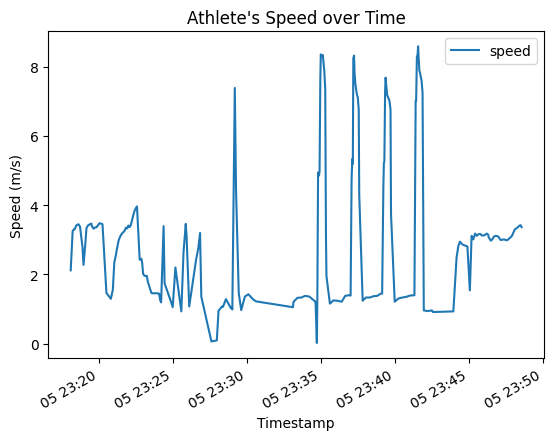

In [6]:
points.plot(x="Timestamp", y="speed", title="Athlete's Speed over Time", xlabel="Timestamp", ylabel="Speed (m/s)")

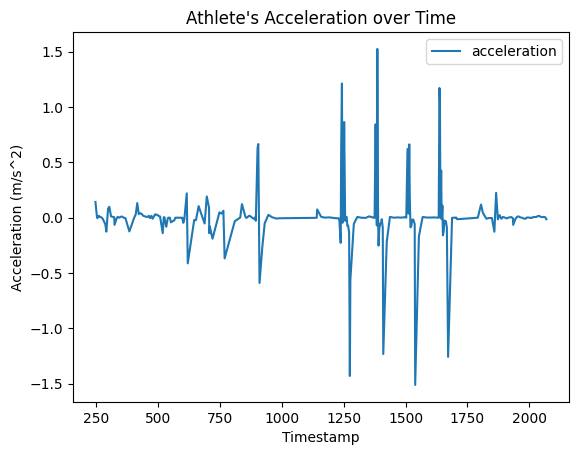

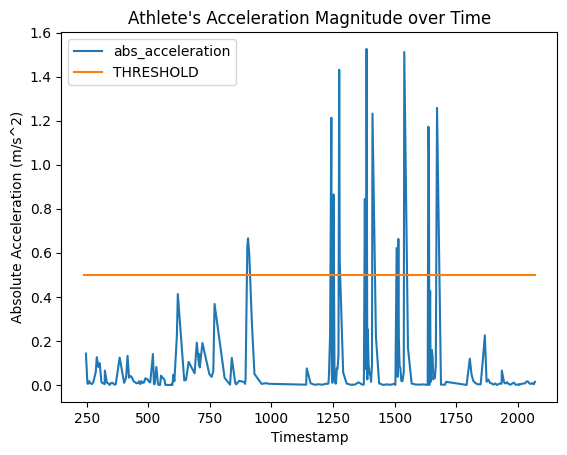

In [68]:
points["acceleration"] = points.speed.diff() / points.Timestamp.diff().dt.total_seconds()
points["abs_acceleration"] = points.acceleration.abs()
points.plot(x="time_after_start", y="acceleration", title="Athlete's Acceleration over Time", xlabel="Timestamp", ylabel="Acceleration (m/s^2)")
points["THRESHOLD"] = ACCELERATION_THRES
points.plot(x="time_after_start", y=["abs_acceleration", "THRESHOLD"], title="Athlete's Acceleration Magnitude over Time", xlabel="Timestamp", ylabel="Absolute Acceleration (m/s^2)")
points = points.drop(columns=["THRESHOLD"])

In [37]:
ACCELERATION_THRES = 0.5
predictions = points[points.abs_acceleration > ACCELERATION_THRES].time_after_start.reset_index(drop=True)
predictions

0      902.0
1      905.0
2      910.0
3     1240.0
4     1243.0
5     1252.0
6     1275.0
7     1277.0
8     1379.0
9     1386.0
10    1410.0
11    1508.0
12    1515.0
13    1539.0
14    1637.0
15    1639.0
16    1672.0
Name: time_after_start, dtype: float64

In [69]:
TIME_THRESHOLD = 12

def grouping_1d(preds):
    """Given an input series of timestamps, 
    group timestamps together and only take the first timestamp."""
    i = 0
    final_preds = []
    while i < len(preds):
        group = preds[(preds[i] <= preds) & 
                      (preds <= preds[i] + TIME_THRESHOLD)]
        # pick the first one as we want 
        # the start of the lap/change in speed
        final_preds.append(group.iloc[0])
        i = group.last_valid_index() + 1

    return final_preds

grouping_1d(predictions)

[902.0, 1240.0, 1275.0, 1379.0, 1410.0, 1508.0, 1539.0, 1637.0, 1672.0]

In [5]:
laps

,Timestamp,start_pos_lat,start_pos_long,end_pos_lat,end_pos_long,total_timer_time,total_distance,avg_speed,lap_time,lap_distance,start_x,start_y,end_x,end_y,time_after_start
0,2021-04-05 23:34:44+00:00,-43.524427,172.571987,-43.521856,172.576163,NaN,NaN,1.741,1237.247,2153.65,-321.801049,-210.018190,35.215397,50.812525,1237.247
1,2021-04-05 23:35:14+00:00,-43.521841,172.576156,-43.522591,172.575273,NaN,NaN,6.655,29.740,197.93,34.802909,52.550182,-42.327888,-25.474430,1266.987
2,2021-04-05 23:37:01+00:00,-43.522652,172.575278,-43.521829,172.576152,NaN,NaN,1.561,106.812,166.72,-42.410565,-32.338633,34.544362,53.875464,1373.799
3,2021-04-05 23:37:30+00:00,-43.521808,172.576149,-43.522568,172.57533,NaN,NaN,6.658,29.235,194.65,34.427689,56.236064,-37.552770,-23.285837,1403.034
4,2021-04-05 23:39:09+00:00,-43.522626,172.57534,-43.521829,172.576161,NaN,NaN,1.607,99.272,159.57,-37.271026,-29.802690,35.293835,53.812597,1502.306
5,2021-04-05 23:39:39+00:00,-43.521811,172.576163,-43.522604,172.575284,NaN,NaN,6.652,29.936,199.14,35.555444,55.763467,-41.571774,-26.965925,1532.242
6,2021-04-05 23:41:20+00:00,-43.522604,172.575284,-43.521846,172.57615,NaN,NaN,1.485,100.999,150.03,-41.571774,-26.965925,34.263017,52.028681,1633.241
7,2021-04-05 23:41:49+00:00,-43.521821,172.576144,-43.522543,172.575281,NaN,NaN,6.953,28.494,198.12,33.947874,54.748830,-41.340961,-20.214980,1661.735
8,2021-04-05 23:48:37+00:00,-43.522602,172.575291,-43.523304,172.567483,NaN,NaN,2.260,406.732,919.39,-40.995613,-26.792381,-676.074280,-59.698027,2068.467


In [71]:
events

,Timestamp,event,event_type
0,2021-04-05 23:14:06+00:00,timer,start
1,2021-04-05 23:48:34+00:00,38,marker
2,2021-04-05 23:48:35+00:00,timer,stop_all


In [70]:
ACCELERATION_THRES = 0.5

def predictor_acceleration(points):
    """Simple predictor that makes predictions off the acceleration of the athlete"""
    points["acceleration"] = points.speed.diff() / points.Timestamp.diff().dt.total_seconds()
    points["abs_acceleration"] = points.acceleration.abs()

    predictions = points[points.abs_acceleration > ACCELERATION_THRES].time_after_start.reset_index(drop=True)
    return grouping_1d(predictions)
    


pred = predictor_acceleration(points)
print("Predicted:", pred)
print("Actual:   ", laps.time_after_start.values)

Predicted: [902.0, 1240.0, 1275.0, 1379.0, 1410.0, 1508.0, 1539.0, 1637.0, 1672.0]
Actual:    [1237.247 1266.987 1373.799 1403.034 1502.306 1532.242 1633.241 1661.735
 2068.467]


In [67]:
from eval import evaluate

evaluate(laps.time_after_start.values, pred)

46.60100000000011

In [1]:
import lap_times
import numpy as np

# for d in range(1, 10, 2):
#     lap_times.main(d)

lap_times.main(4)

/home/gareth/Documents/Uni/2023/cosc470/track_location/keypoint_detection_track.py:63: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  img = torch.Tensor([np_fig[0::3], np_fig[1::3], np_fig[2::3]])   # needs to be in C, H, W format. Image is 1000x1000. Colour RGB


Num training examples 134362
New Num training examples 122990
Predicted:  [466.0, 473.5, 507.5, 540.5, 656.0, 690.0, 724.0, 877.0, 905.0, 1034.0, 1059.5, 1183.2857142857142, 1209.0, 1327.5, 1335.0, 1354.0, 1683.3333333333333, 1692.0]
Actual:  [ 467.996  540.507  655.028  724.451  875.991  906.194 1031.631 1060.502
 1180.201 1208.92  1326.931 1353.696 1868.394]
Predicted:  [1237.0, 1268.3333333333333, 1379.5, 1402.5, 1508.5, 1531.5, 1637.5, 1664.0]
Actual:  [1237.247 1266.987 1373.799 1403.034 1502.306 1532.242 1633.241 1661.735
 2068.467]


/home/gareth/Documents/Uni/2023/cosc470/models.py:208: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  workout_output = grouping_1d(pd.Series(workout_output))  # thin the predictions


Predicted:  [1706.5, 1715.0, 1758.0, 1849.0, 1883.0, 1916.5, 2040.0, 2072.5, 2107.0, 2230.0, 2297.5, 2354.0, 2424.0, 2926.5, 2941.0, 2978.0, 3065.0, 3074.5, 3138.5, 3254.0, 3264.5, 3327.0, 3447.0, 3454.0, 3508.0, 3516.0]
Actual:  [1707.662 1758.046 1848.423 1916.989 2038.279 2106.686 2227.451 2296.038
 2924.638 2977.033 3069.275 3139.338 3259.831 3326.726 3447.072 3506.203
 4689.904]
Predicted:  [1537.0, 1548.5, 1730.5, 1799.5, 1890.0, 2149.0, 2180.0, 2276.0, 2309.5, 2399.5, 2431.0, 3119.0, 3145.5, 3261.0, 3291.5, 3423.5, 3536.0, 3568.0]
Actual:  [1871.205 1925.616 2005.296 2053.983 2130.114 2179.753 2259.109 2309.056
 2382.704 2433.598 3118.392 3146.686 3260.709 3291.984 3396.184 3425.655
 3537.722 3568.547 3977.949]
Predicted:  [1681.0, 1936.090909090909, 2247.0, 2332.5, 2418.0, 2614.5]
Actual:  [1933.789 2618.689 3420.526]
[(14.571670329670322, 25.3068544973545), (57.66359999999977, 164.93031818181814), (74.04340000000009, 345.45863095238104), (67.01517647058839, 7.932818181818313),